In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load and preprocess
df = pd.read_csv("/content/TTSWING.csv")
# Drop irrelevant columns
exclude_cols = ['id', 'date', 'testmode', 'teststage', 'fileindex', 'count']
X = df.drop(columns=exclude_cols)

# Identify categorical columns
cat_cols = X.select_dtypes(include='object').columns

# Label encode each categorical column
for col in cat_cols:
    X[col] = LabelEncoder().fit_transform(X[col])

# Now apply scaling
X_scaled = StandardScaler().fit_transform(X)

# Isolation Forest

In [3]:
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
df['iso_anomaly'] = iso_forest.fit_predict(X_scaled)
df['iso_anomaly'] = df['iso_anomaly'].map({1: 0, -1: 1})


# One Class SVM

In [4]:
oc_svm = OneClassSVM(kernel='rbf', nu=0.05, gamma='scale')
df['svm_anomaly'] = oc_svm.fit_predict(X_scaled)
df['svm_anomaly'] = df['svm_anomaly'].map({1: 0, -1: 1})


# Local Outlier Factor

In [5]:
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
df['lof_anomaly'] = lof.fit_predict(X_scaled)
df['lof_anomaly'] = df['lof_anomaly'].map({1: 0, -1: 1})

<ipython-input-9-56993ea40b55>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


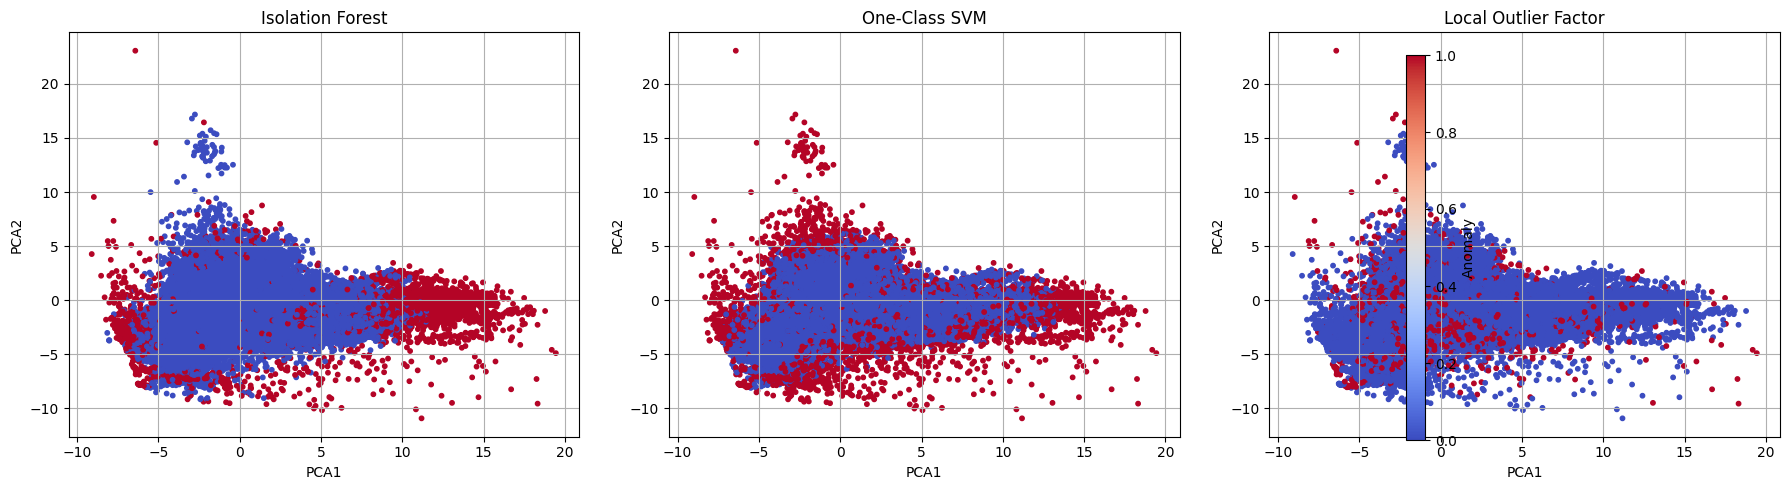

In [9]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

def plot_pca(title, labels):
    plt.figure(figsize=(6, 4))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='coolwarm', s=10)
    plt.title(title)
    plt.xlabel("PCA1")
    plt.ylabel("PCA2")
    plt.grid(True)
    plt.colorbar(label='Anomaly')
    plt.tight_layout()
    plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

titles = ["Isolation Forest", "One-Class SVM", "Local Outlier Factor"]
anomalies = ['iso_anomaly', 'svm_anomaly', 'lof_anomaly']

for ax, title, col in zip(axes, titles, anomalies):
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=df[col], cmap='coolwarm', s=10)
    ax.set_title(title)
    ax.set_xlabel("PCA1")
    ax.set_ylabel("PCA2")
    ax.grid(True)

fig.colorbar(scatter, ax=axes, orientation='vertical', label='Anomaly')
plt.tight_layout()
plt.show()


# Evaluation: Outlier Agreement

In [7]:
from sklearn.metrics import confusion_matrix

# Agreement score matrix
df['sum_anomalies'] = df[['iso_anomaly', 'svm_anomaly', 'lof_anomaly']].sum(axis=1)

# Simple consensus metric
print("Agreed anomalies (2 or more models):", sum(df['sum_anomalies'] >= 2))
print("Agreed normal points:", sum(df['sum_anomalies'] == 0))


Agreed anomalies (2 or more models): 3081
Agreed normal points: 86124


In [8]:
df.to_csv("TTSwing_with_anomalies_all_models.csv", index=False)
